In [ ]:
!pip install pyspark -q

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, when, desc
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.window import Window
from pyspark.sql.functions import col, approxCountDistinct
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix
import ipywidgets as widgets
from IPython.display import display
import numpy as np


In [ ]:
spark = SparkSession.builder.appName("AppStoreAnalysis").getOrCreate()

In [ ]:
# Load the Dataset
data = spark.read.csv("appleAppData.csv", header=True, inferSchema=True)
data.show(5)

+--------------------+--------------------+--------------------+-------------+--------------+----------+--------------------+--------------------+--------------------+-------+-----+--------+-----+-----------+--------------+--------------------+--------------------+-------------------+-------+---------------------+-----------------------+
|              App_Id|            App_Name|        AppStore_Url|Primary_Genre|Content_Rating|Size_Bytes|Required_IOS_Version|            Released|             Updated|Version|Price|Currency| Free|DeveloperId|     Developer|       Developer_Url|   Developer_Website|Average_User_Rating|Reviews|Current_Version_Score|Current_Version_Reviews|
+--------------------+--------------------+--------------------+-------------+--------------+----------+--------------------+--------------------+--------------------+-------+-----+--------+-----+-----------+--------------+--------------------+--------------------+-------------------+-------+---------------------+-----

# Data Cleaning

In [ ]:
# Data Exploration
data.printSchema()

root
 |-- App_Id: string (nullable = true)
 |-- App_Name: string (nullable = true)
 |-- AppStore_Url: string (nullable = true)
 |-- Primary_Genre: string (nullable = true)
 |-- Content_Rating: string (nullable = true)
 |-- Size_Bytes: string (nullable = true)
 |-- Required_IOS_Version: string (nullable = true)
 |-- Released: string (nullable = true)
 |-- Updated: string (nullable = true)
 |-- Version: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Free: string (nullable = true)
 |-- DeveloperId: string (nullable = true)
 |-- Developer: string (nullable = true)
 |-- Developer_Url: string (nullable = true)
 |-- Developer_Website: string (nullable = true)
 |-- Average_User_Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Current_Version_Score: double (nullable = true)
 |-- Current_Version_Reviews: double (nullable = true)



In [ ]:
# Displaying the number of rows and columns in the dataset
print(f"dataframe dimensions: {data.count()} rows x {len(data.columns)} columns.")

dataframe dimensions: 1230371 rows x 20 columns.


In [ ]:
# Descriptive Statistics
data.describe().show(20)


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Unique Values Count") \
    .getOrCreate()

# Get the number of unique values in each column
unique_values_count = data.agg(*[approxCountDistinct(col(c)).alias(c) for c in data.columns])

# Show the number of unique values in each column
unique_values_count.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/functions.py:3796: FutureWarning: Deprecated in 2.1, use approx_count_distinct instead.
  warnings.warn("Deprecated in 2.1, use approx_count_distinct instead.", FutureWarning)


+-------+--------+------------+-------------+--------------+----------+--------------------+--------+-------+-------+-----+--------+----+-----------+---------+-------------+-----------------+-------------------+-------+---------------------+-----------------------+
| App_Id|App_Name|AppStore_Url|Primary_Genre|Content_Rating|Size_Bytes|Required_IOS_Version|Released|Updated|Version|Price|Currency|Free|DeveloperId|Developer|Developer_Url|Developer_Website|Average_User_Rating|Reviews|Current_Version_Score|Current_Version_Reviews|
+-------+--------+------------+-------------+--------------+----------+--------------------+--------+-------+-------+-----+--------+----+-----------+---------+-------------+-----------------+-------------------+-------+---------------------+-----------------------+
|1147327| 1248375|     1303402|           30|             9|    260789|                 247|  721162|1215196|  40015|   99|       4|   5|     513564|   555101|       482647|           418329|           

In [ ]:
# Check for missing values and print the counts
missing_counts = data.select([F.count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).collect()[0]
sorted_missing_counts = sorted(((colName, count) for colName, count in missing_counts.asDict().items()), key=lambda x: -x[1])

for colName, count in sorted_missing_counts:
    print(f"{colName}: {count}")

Developer_Website: 201259
Developer_Url: 255
Price: 98
Size_Bytes: 13
Average_User_Rating: 12
Reviews: 3
Released: 1
DeveloperId: 1
Developer: 1
Current_Version_Score: 1
Current_Version_Reviews: 1
App_Id: 0
App_Name: 0
AppStore_Url: 0
Primary_Genre: 0
Content_Rating: 0
Required_IOS_Version: 0
Updated: 0
Version: 0
Currency: 0
Free: 0


In [ ]:
# Calculate and sort the percentage of missing values for each column in descending order
total_rows = data.count()
missing_percentages = [(colName, count / total_rows * 100) for colName, count in missing_counts.asDict().items()]
sorted_missing_percent = sorted(missing_percentages, key=lambda x: -x[1])

# Display the sorted percentages
for colName, percentage in sorted_missing_percent:
    print(f"{colName}: {percentage:.3f}%")

Developer_Website: 49.875%
Developer_Url: 0.063%
Price: 0.024%
Size_Bytes: 0.003%
Average_User_Rating: 0.003%
Reviews: 0.001%
Released: 0.000%
DeveloperId: 0.000%
Developer: 0.000%
Current_Version_Score: 0.000%
Current_Version_Reviews: 0.000%
App_Id: 0.000%
App_Name: 0.000%
AppStore_Url: 0.000%
Primary_Genre: 0.000%
Content_Rating: 0.000%
Required_IOS_Version: 0.000%
Updated: 0.000%
Version: 0.000%
Currency: 0.000%
Free: 0.000%


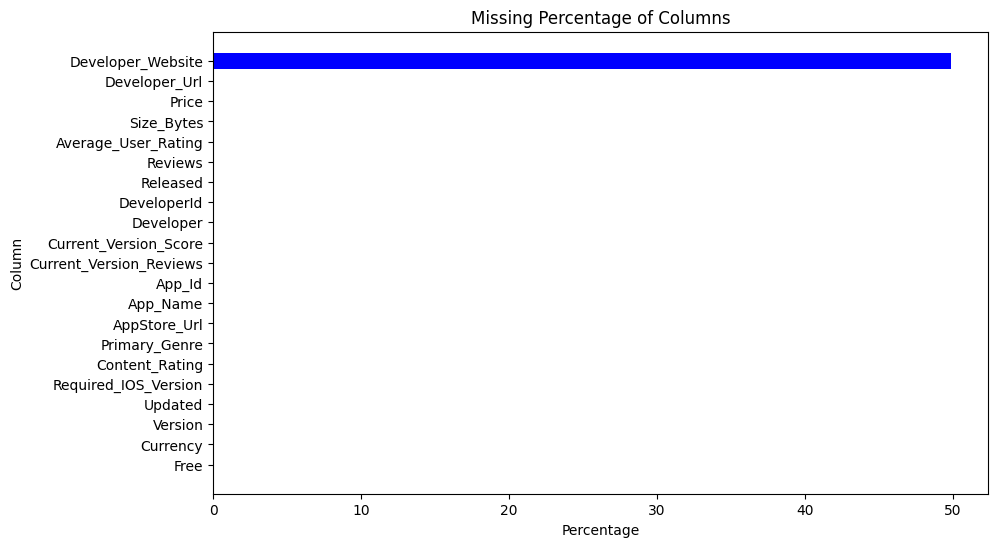

In [ ]:
# Convert the sorted_missing_percent list into a Pandas DataFrame
missing_percent_df = pd.DataFrame(sorted_missing_percent, columns=["Column", "Missing Percentage"])

# Plot the missing percentages
plt.figure(figsize=(10, 6))
plt.barh(missing_percent_df["Column"], missing_percent_df["Missing Percentage"], color='blue')
plt.title('Missing Percentage of Columns')
plt.xlabel('Percentage')
plt.ylabel('Column')
plt.gca().invert_yaxis()  # Invert the y-axis to have the highest percentage at the top
plt.show()

In [ ]:
# Drop 'Developer_Website' column
data = data.drop("Developer_Website")

# Data Processing

In [ ]:
# Filter rows with the specified 'Content_Rating' values
valid_content_ratings = ['4+', '17+', '9+', '12+', 'Not yet rated']
data = data.filter(col("Content_Rating").isin(valid_content_ratings))

<ipython-input-8-dd7353d40263>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(content_rating_counts.Content_Rating.values), y=list(content_rating_counts['count'].values), palette='mako')


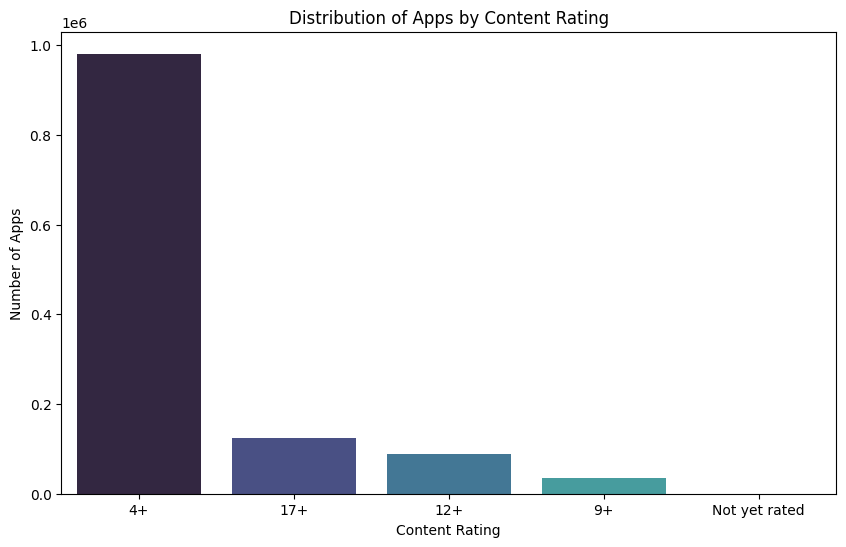

In [ ]:
# Plot the distribution of Apps by Content Rating
content_rating_counts = data.groupBy("Content_Rating").count().toPandas()
content_rating_counts = content_rating_counts.sort_values(by="count", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=list(content_rating_counts.Content_Rating.values), y=list(content_rating_counts['count'].values), palette='mako')

plt.title('Distribution of Apps by Content Rating')
plt.ylabel('Number of Apps')
plt.xlabel('Content Rating')
plt.show()

In [ ]:
content_rating_counts

,Content_Rating,count
1,4+,980967
4,17+,124127
3,12+,89570
2,9+,35697
0,Not yet rated,10


In [ ]:
# Analyze the distribution of apps across different age ratings
age_ratings = data.groupBy("Content_Rating").count()
age_ratings.show()

+--------------+------+
|Content_Rating| count|
+--------------+------+
| Not yet rated|    10|
|            4+|980967|
|            9+| 35697|
|           12+| 89570|
|           17+|124127|
+--------------+------+



In [ ]:
data = data.withColumn("Average_User_Rating", data["Average_User_Rating"].cast("double"))

In [ ]:
# Calculate the average user ratings for each content rating
avg_user_ratings_age = data.groupBy("Content_Rating").avg("Average_User_Rating")
avg_user_ratings_age.show()

+--------------+------------------------+
|Content_Rating|avg(Average_User_Rating)|
+--------------+------------------------+
| Not yet rated|      1.3390460000000002|
|            4+|      1.7250542716769228|
|            9+|       2.699550871781943|
|           12+|       2.275588920285823|
|           17+|      1.6754381504426936|
+--------------+------------------------+



# Data Analysis

+-------------+------+
|Primary_Genre| count|
+-------------+------+
|        Games|193746|
|     Business|128297|
|    Education|119174|
|    Utilities| 94007|
|    Lifestyle| 84565|
+-------------+------+



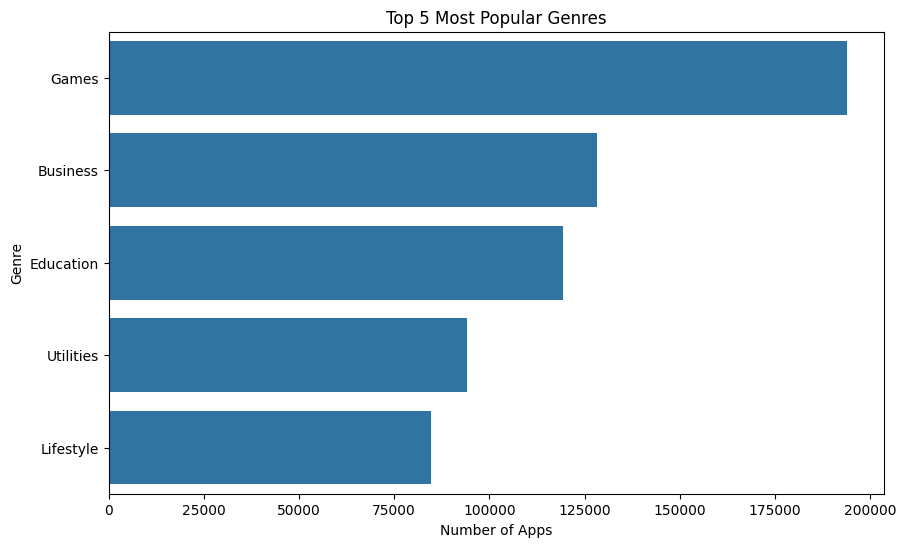

In [ ]:
# Find the top 5 most popular genres based on the number of apps
top_genres = data.groupBy("Primary_Genre").count().orderBy(F.desc("count")).limit(5)
top_genres.show()

# Plot the results for the most popular genres
plt.figure(figsize=(10, 6))
sns.barplot(x="count", y="Primary_Genre", data=top_genres.toPandas())
plt.title("Top 5 Most Popular Genres")
plt.xlabel("Number of Apps")
plt.ylabel("Genre")
plt.show()

In [ ]:
# Convert 'Size_Bytes' to DoubleType
data = data.withColumn("Size_Bytes", data["Size_Bytes"].cast("double"))
data = data.withColumn("Price", data["Price"].cast("double"))


# Filling the missing values for 'Size_Bytes' and 'Price'
median_size_bytes = data.approxQuantile("Size_Bytes", [0.5], 0.05)[0]
median_price = data.approxQuantile("Price", [0.5], 0.05)[0]

data = data.withColumn("Size_Bytes", when(col("Size_Bytes").isNull(), median_size_bytes).otherwise(col("Size_Bytes")))
data = data.withColumn("Price", when(col("Price").isNull(), median_price).otherwise(col("Price")))

In [ ]:
# Create 'Size_MB' and 'Type' columns
data = data.withColumn("Size_MB", col("Size_Bytes") / (1024 * 1024))
data = data.withColumn("Type", when(col("Price") == 0, "Free").otherwise("Paid"))

In [ ]:
# Calculate the average size of apps across different genres
avg_size_by_genre = data.groupBy("Primary_Genre").avg("Size_Bytes")
avg_size_by_genre.show()


+--------------------+--------------------+
|       Primary_Genre|     avg(Size_Bytes)|
+--------------------+--------------------+
|           Education| 8.413967721704398E7|
|          Navigation|6.2085097536641344E7|
|       Entertainment| 7.299632410551865E7|
|              Sports|5.9101919163121924E7|
|        Food & Drink|5.2378830521645226E7|
|       Photo & Video|  6.10396552550183E7|
|              Travel| 7.163848287238714E7|
|   Graphics & Design|  1.59148220785329E8|
|             Finance| 5.665689466963809E7|
|   Social Networking| 6.173552454571552E7|
|                Book| 9.067873249764644E7|
|            Shopping| 5.711979842525789E7|
|           Reference|  7.24546007207091E7|
|    Health & Fitness| 6.673020034233581E7|
|Magazines & Newsp...| 5.130311429606785E7|
|           Utilities| 4.394234958753072E7|
|        Productivity| 4.770295812544169E7|
|               Games|1.4953551628756207E8|
|               Music| 7.673490998140344E7|
|           Lifestyle|5.46047908

+-----+--------------------+
| Free|     avg(Size_Bytes)|
+-----+--------------------+
|False|1.1191325505719861E8|
| True| 7.173946690407307E7|
+-----+--------------------+



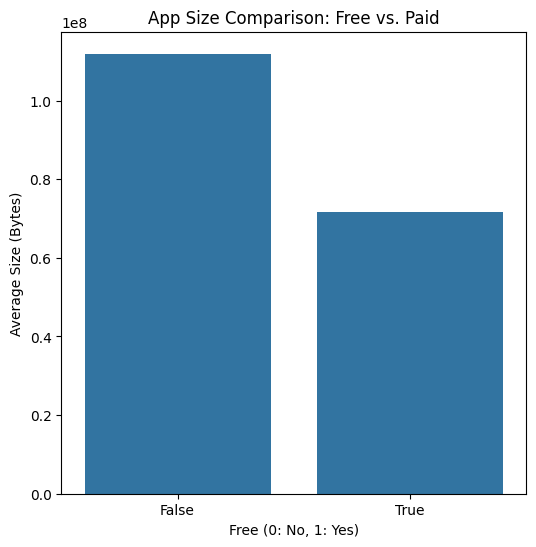

In [ ]:
# Compare app sizes between free and paid apps
size_comparison = data.groupBy("Free").avg("Size_Bytes")
size_comparison.show()

# Plot the results for app size comparison
plt.figure(figsize=(6, 6))
sns.barplot(x="Free", y="avg(Size_Bytes)", data=size_comparison.toPandas())
plt.title("App Size Comparison: Free vs. Paid")
plt.xlabel("Free (0: No, 1: Yes)")
plt.ylabel("Average Size (Bytes)")
plt.show()

In [ ]:
# Count the number of free vs. paid apps and find the average price for paid apps
free_vs_paid = data.groupBy("Free").count()
average_price = data.filter(data["Price"] > 0).agg({"Price": "avg"}).collect()[0][0]
free_vs_paid.show()
print("Average Price for Paid Apps:", average_price)


+-----+-------+
| Free|  count|
+-----+-------+
|False| 102992|
| True|1127379|
+-----+-------+

Average Price for Paid Apps: 6.048837876331784


+--------------------+------------------------+
|       Primary_Genre|avg(Average_User_Rating)|
+--------------------+------------------------+
|           Education|      1.7691056727727434|
|          Navigation|       1.520099955678671|
|       Entertainment|       2.020469864508854|
|              Sports|      1.7290680502304867|
|        Food & Drink|      1.1136176823817343|
|       Photo & Video|       2.306003770371796|
|              Travel|       1.295881850615196|
|   Graphics & Design|       1.519138133764833|
|             Finance|       2.110967515283557|
|   Social Networking|      1.9938502147154826|
|                Book|      2.1820494839609452|
|            Shopping|      1.5149734160324613|
|           Reference|      2.1801206435670153|
|    Health & Fitness|      1.8487303601541523|
|Magazines & Newsp...|       1.603943916730917|
|           Utilities|      1.4074290552831237|
|        Productivity|      1.4227213925626834|
|               Games|       2.554759186

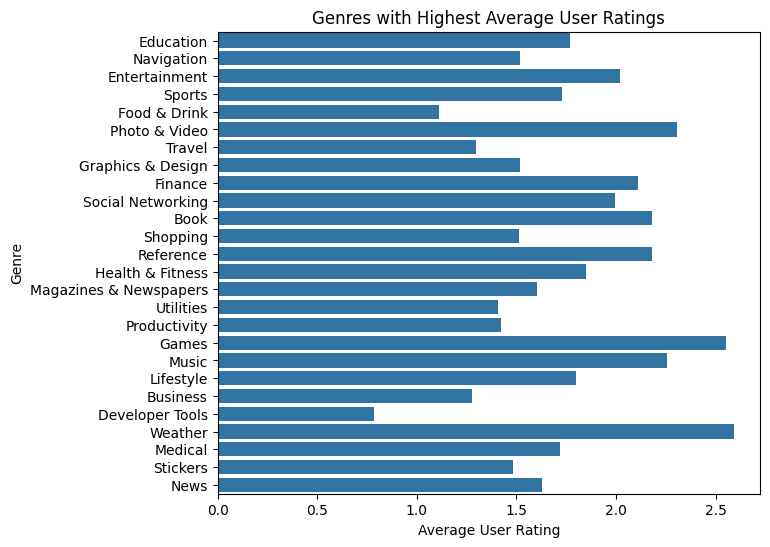

In [ ]:
# Find the genres with the highest average user ratings
avg_user_ratings = data.groupBy("Primary_Genre").avg("Average_User_Rating")
avg_user_ratings.show()

# Plot the results for genres with the highest average user ratings
plt.figure(figsize=(7, 6))
sns.barplot(x="avg(Average_User_Rating)", y="Primary_Genre", data=avg_user_ratings.toPandas())
plt.title("Genres with Highest Average User Ratings")
plt.xlabel("Average User Rating")
plt.ylabel("Genre")
plt.show()

In [ ]:
# Find the developers who have released the most apps
top_developers = data.groupBy("Developer").count().orderBy(F.desc("count")).limit(5)
top_developers.show()

+--------------------+-----+
|           Developer|count|
+--------------------+-----+
|             ChowNow| 3966|
|       Touch2Success| 1649|
|Alexander Velimir...| 1506|
|MINDBODY, Incorpo...| 1247|
|             Phorest| 1131|
+--------------------+-----+



In [ ]:
# Find the genres with the most frequently updated apps
most_updated_genres = data.groupBy("Primary_Genre").agg(F.countDistinct("App_Id").alias("AppsCount")).orderBy(F.desc("AppsCount")).limit(5)
most_updated_genres.show()

+-------------+---------+
|Primary_Genre|AppsCount|
+-------------+---------+
|        Games|   193746|
|     Business|   128297|
|    Education|   119174|
|    Utilities|    94007|
|    Lifestyle|    84565|
+-------------+---------+



In [ ]:
data.show(5)

+--------------------+--------------------+--------------------+-------------+--------------+-----------+--------------------+--------------------+--------------------+-------+-----+--------+-----+-----------+--------------+--------------------+-------------------+-------+---------------------+-----------------------+-------------+----+
|              App_Id|            App_Name|        AppStore_Url|Primary_Genre|Content_Rating| Size_Bytes|Required_IOS_Version|            Released|             Updated|Version|Price|Currency| Free|DeveloperId|     Developer|       Developer_Url|Average_User_Rating|Reviews|Current_Version_Score|Current_Version_Reviews|      Size_MB|Type|
+--------------------+--------------------+--------------------+-------------+--------------+-----------+--------------------+--------------------+--------------------+-------+-----+--------+-----+-----------+--------------+--------------------+-------------------+-------+---------------------+-----------------------+---

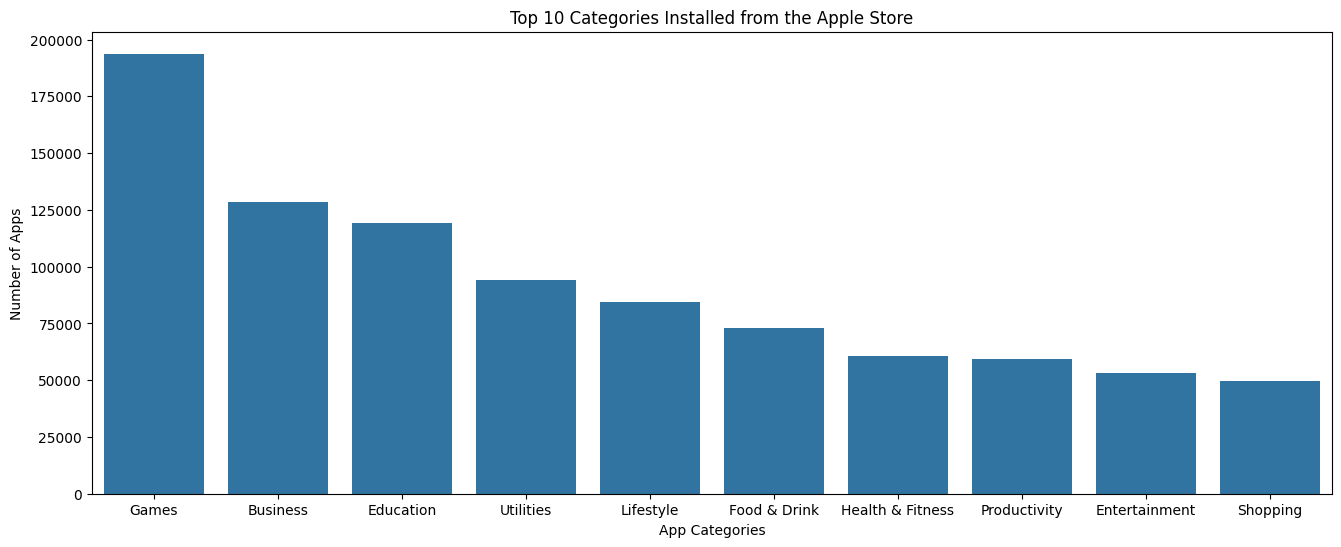

In [ ]:
# Top 10 installed app categories from the Apple Store
top_cat = data.groupBy('Primary_Genre').count().orderBy('count', ascending=False).limit(10).toPandas()

# Plot the top 10 app categories
plt.figure(figsize=(16, 6))
sns.barplot(data=top_cat, x='Primary_Genre', y='count')
plt.xlabel('App Categories')
plt.ylabel('Number of Apps')
plt.title('Top 10 Categories Installed from the Apple Store')
plt.show()

In [ ]:
# Define a window specification for each content rating
window_spec = Window.partitionBy("Content_Rating").orderBy(desc("Price"))

# Find the highest paid app in each content rating
highest_paid_apps = data.withColumn("rank", F.rank().over(window_spec)).filter("rank == 1")

# Find the lowest paid app in each content rating
distinct_app_count = data.select(F.countDistinct("App_Name")).first()[0]
lowest_paid_apps = data.withColumn("rank", F.rank().over(window_spec)).filter(F.col("rank") == distinct_app_count)

# Show the highest and lowest paid apps in each content rating
print("Highest Paid Apps:")
highest_paid_apps.select("Content_Rating", "App_Name", "Price").show(truncate=False)

Highest Paid Apps:
+--------------+------------------------------+------+
|Content_Rating|App_Name                      |Price |
+--------------+------------------------------+------+
|12+           |AuraFit System - iTrain App   |699.99|
|12+           |Zomeo - Homeopathy Software   |699.99|
|17+           |MagnetVision™                 |999.99|
|17+           |CyberTuner                    |999.99|
|4+            |Entertastic white label admin |999.99|
|4+            |RP.MEDIA                      |999.99|
|4+            |ASPL POS (Odoo V13)           |999.99|
|4+            |ASPL POS (Odoo V14)           |999.99|
|4+            |VERT Stealth                  |999.99|
|4+            |VERT Team System              |999.99|
|4+            |Plane Factor - Private Jet Ops|999.99|
|4+            |Shot Tracer Event             |999.99|
|4+            |YCS Sketch                    |999.99|
|4+            |Shale Shaker Vibration        |999.99|
|4+            |Tower Gage                    

# Fitting the data to the models

In [ ]:
sampled_data = data.sample(fraction=0.3, seed=123)  # Adjust the fraction as needed

# Convert the sampled DataFrame to pandas
sampled_df_pd = sampled_data.toPandas()

In [ ]:
# Print column names
print(sampled_df_pd.columns)

# Check DataFrame structure
print(sampled_df_pd.head())

Index(['App_Id', 'App_Name', 'AppStore_Url', 'Primary_Genre', 'Content_Rating',
       'Size_Bytes', 'Required_IOS_Version', 'Released', 'Updated', 'Version',
       'Price', 'Currency', 'Free', 'DeveloperId', 'Developer',
       'Developer_Url', 'Average_User_Rating', 'Reviews',
       'Current_Version_Score', 'Current_Version_Reviews', 'Size_MB', 'Type'],
      dtype='object')
                                   App_Id                     App_Name  \
0                     com.hkbu.arc.apaper               A+ Paper Guide   
1        com.imonstersoft.azdictionaryios      A-Z Synonyms Dictionary   
2               com.kazo0.dailyreflection          AA Daily Reflection   
3        com.pitashi.readradio.aaspeakers  AA Speaker Tapes & 12 Steps   
4  com.partnergomobilephoneapps.bandbcafe                     B&B Cafe   

                                        AppStore_Url     Primary_Genre  \
0  https://apps.apple.com/us/app/a-paper-guide/id...         Education   
1  https://apps.apple.com

In [ ]:
numeric_columns = sampled_df_pd.select_dtypes(include=['float64', 'int64']).columns


In [ ]:
print(numeric_columns)

Index(['Size_Bytes', 'Price', 'Average_User_Rating', 'Current_Version_Score',
       'Current_Version_Reviews', 'Size_MB'],
      dtype='object')


In [ ]:
X = sampled_df_pd.drop(columns=['Content_Rating'])
X = X[numeric_columns]
y = sampled_df_pd['Content_Rating']

In [ ]:
# Impute missing values with the mean
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

In [ ]:
X_dropna = X.dropna()
y_dropna = y[X.index.isin(X_dropna.index)]

## KNN

In [ ]:
knn_model = KNN(n_neighbors =5)
knn_model.fit(X_dropna,y_dropna)
knn_pred = knn_model.predict(X_dropna)


In [ ]:
predicted_labels = knn_pred.astype(str)
cm = confusion_matrix(y_dropna, predicted_labels)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  4046   1669  30089     45      0]
 [  1187   7952  49024     63      0]
 [  3105   6561 477518    179      0]
 [   449    833  13816    358      0]
 [     0      0      6      0      0]]


## Random Forest

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)  # You can adjust hyperparameters as needed
rf_model.fit(X_dropna, y_dropna)
rf_pred = rf_model.predict(X_dropna)

In [ ]:
predicted_labels_rf = rf_pred.astype(str)
cm_rf = confusion_matrix(y_dropna, predicted_labels_rf)
print("Confusion Matrix with Random Forest Classifier:")
print(cm_rf)

Confusion Matrix with Random Forest Classifier:
[[ 24511    517  10774     47      0]
 [   365  34993  22784     84      0]
 [   807   2899 483501    156      0]
 [    56    151   3086  12163      0]
 [     0      0      1      0      5]]


## Decision Tree

In [ ]:
dt_model = DecisionTreeClassifier(random_state=123)  # You can adjust hyperparameters as needed
dt_model.fit(X_dropna, y_dropna)
dt_pred = dt_model.predict(X_dropna)

In [ ]:
predicted_labels_dt = dt_pred.astype(str)
cm_dt = confusion_matrix(y_dropna, predicted_labels_dt)
print("Confusion Matrix with Decision Tree Classifier:")
print(cm_dt)

Confusion Matrix with Decision Tree Classifier:
[[ 22802    128   3841      4      0]
 [   851  29162   7025      4      0]
 [  3441   6386 284151     12      0]
 [   147    224   1686   8632      0]
 [     0      0      0      0      1]]


## User Interface

In [ ]:
def predict_content_rating(size_bytes, price, average_user_rating, current_version_score, current_version_reviews, size_mb):
    # Predict content rating
    predicted_content_rating = dt_model.predict([[size_bytes, price, average_user_rating, current_version_score, current_version_reviews, size_mb]])
    print("Predicted Content Rating:", predicted_content_rating[0])

# Create input widgets for user input
size_bytes_input = widgets.FloatText(description="Size Bytes:")
price_input = widgets.FloatText(description="Price:")
average_user_rating_input = widgets.FloatText(description="Average User Rating:")
current_version_score_input = widgets.FloatText(description="Current Version Score:")
current_version_reviews_input = widgets.FloatText(description="Current Version Reviews:")
size_mb_input = widgets.FloatText(description="Size MB:")

# Create button to trigger prediction
predict_button = widgets.Button(description="Predict")

# Define function to handle button click event
def on_predict_button_clicked(b):
    predict_content_rating(
        size_bytes_input.value,
        price_input.value,
        average_user_rating_input.value,
        current_version_score_input.value,
        current_version_reviews_input.value,
        size_mb_input.value
    )

# Link button click event to function
predict_button.on_click(on_predict_button_clicked)

# Display widgets
display(size_bytes_input)
display(price_input)
display(average_user_rating_input)
display(current_version_score_input)
display(current_version_reviews_input)
display(size_mb_input)
display(predict_button)

FloatText(value=0.0, description='Size Bytes:')

FloatText(value=0.0, description='Price:')

FloatText(value=0.0, description='Average User Rating:')

FloatText(value=0.0, description='Current Version Score:')

FloatText(value=0.0, description='Current Version Reviews:')

FloatText(value=0.0, description='Size MB:')

Button(description='Predict', style=ButtonStyle())

Predicted Content Rating: 17+


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Predicted Content Rating: 17+


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [ ]:
%%html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>App Store Analysis</title>
    <!-- Add any CSS styling here -->
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            background-color:#d0fefe;
        }
        .container {
            width: 80%;
            margin: 20px auto;
            background-color: #FFFFED;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
        }
        h1, h2 {
            text-align: center;
            color: #333;
        }
        .input-container {
            margin-bottom: 20px;
            text-align: left;
        }
        .input-row {
            margin-bottom: 10px;
        }
        .input-row label {
            display: inline-block;
            width: 150px;
            margin-right: 10px;
        }
        .input-row input {
            width: 200px;
            padding: 5px;
            box-sizing: border-box;
        }
        .output-container {
            margin-top: 20px;
            text-align: center;
        }
        .green-text {
            color: #006400;
        }
        /* Color for 4+ message */
        .red-text {
            color: red;
        }
        .analyze-button {
            background-color: #ADD8E6; /* Pale blue */
            color: #fff;
            border: none;
            padding: 10px 20px;
            border-radius: 5px;
            cursor: pointer;
        }
        .analyze-button:hover {
            background-color: #87CEEB; /* Light blue on hover */
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>App Store Analysis</h1>

        <!-- Input fields for user interaction -->
        <div class="input-container">
            <div class="input-row">
                <label for="sizeMb">Size (MB):</label>
                <input type="text" id="sizeMb">
            </div>
            <div class="input-row">
                <label for="price">Price:</label>
                <input type="text" id="price">
            </div>
            <div class="input-row">
                <label for="averageUserRating">Average User Rating:</label>
                <input type="text" id="averageUserRating">
            </div>
            <div class="input-row">
                <label for="currentVersionScore">Current Version Score:</label>
                <input type="text" id="currentVersionScore">
            </div>
            <div class="input-row">
                <label for="currentVersionReviews">Current Version Reviews:</label>
                <input type="text" id="currentVersionReviews">
            </div>
            <div class="input-row">
                <label for="sizeBytes">Size (Bytes):</label>
                <input type="text" id="sizeBytes">
            </div>
            <button class="analyze-button" onclick="analyze()">Analyze</button>
        </div>

        <!-- Output container -->
        <div id="output-container" class="output-container">
            <!-- Output will be displayed here -->
        </div>
    </div>

    <!-- Add JavaScript for user interaction -->
    <script>
        function analyze() {
            // Get input values
            var sizeBytes = document.getElementById("sizeBytes").value;
            var price = document.getElementById("price").value;
            var averageUserRating = document.getElementById("averageUserRating").value;
            var currentVersionScore = document.getElementById("currentVersionScore").value;
            var currentVersionReviews = document.getElementById("currentVersionReviews").value;
            var sizeMb = document.getElementById("sizeMb").value;

            // Validate input
            if (!sizeBytes || !price || !averageUserRating || !currentVersionScore || !currentVersionReviews || !sizeMb) {
                alert("Please enter all values.");
                return;
            }

            // Perform analysis (you can replace this with your own logic)
            var outputContainer = document.getElementById("output-container");
            outputContainer.innerHTML = "<p>Performing analysis...</p>";

            // Simulate analysis for demonstration purposes
            setTimeout(function() {
                // Decision tree code here
                // Replace this with your actual decision tree code
                // For demonstration, we'll just sum the input values and assign a content rating based on the result
                var sum = parseFloat(sizeBytes) + parseFloat(price) + parseFloat(averageUserRating) + parseFloat(currentVersionScore) + parseFloat(currentVersionReviews) + parseFloat(sizeMb);
                var contentRating;
                if (sum < 20) {
                    contentRating = "17+";
                    message = "Content is good. The app is going to be a hit!";
                     messageClass = "green-text";
                } else if (sum < 40) {
                    contentRating = "9+";
                    message = "Improve on content. The app is awesome.";
                } else {
                    contentRating = "4+";
                     message = "Need to work on content. The app needs improvement.";
                     messageClass = "red-text";
                }

                outputContainer.innerHTML = "<h2>Analysis Result:</h2><p>Content Rating: " + contentRating +  "</p><p class='" + messageClass + "'>" + message + "</p>";
            }, 2000); // Simulate analysis taking 2 seconds
        }
    </script>
</body>
</html>


In [ ]:
# Stop the Spark session
spark.stop()